# Brain Tumor Segmentation using U-Net

## Importing Libraries & Defining Paths

In [1]:
import os
import glob
import json
import numpy as np
import cv2

from tensorflow.keras import layers
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.layers import Conv2D,Flatten,Dropout,BatchNormalization,Dense
from tensorflow.keras.callbacks import ReduceLROnPlateau,EarlyStopping,ModelCheckpoint

In [2]:
import os
print(os.listdir('/kaggle/input/'))

['README.txt', 'valid', 'test', 'train']


In [3]:
train_path = '/kaggle/input/train'
test_path = '/kaggle/input/test'
valid_path = '/kaggle/input/valid'

# Function to check if a path exists
def check_path(path):
    if os.path.exists(path):
        print(f"Path exists: {path}")
    else:
        print(f"Path does NOT exist: {path}")

# Check the paths
check_path(train_path)
check_path(test_path)
check_path(valid_path)

Path exists: /kaggle/input/train
Path exists: /kaggle/input/test
Path exists: /kaggle/input/valid


In [4]:
train_data=[image for image in os.listdir(train_path)]
test_data=[image for image in os.listdir(test_path)]
valid_data=[image for image in os.listdir(valid_path)]

In [5]:
# Check the number of images in each dataset
print(f"Number of training images: {len(train_data)}")
print(f"Number of test images: {len(test_data)}")
print(f"Number of validation images: {len(valid_data)}")

# Check the shape of some sample images to ensure consistency
sample_image_path = os.path.join(train_path, train_data[0])
sample_image = cv2.imread(sample_image_path)
print(f"Sample image shape: {sample_image.shape}")

Number of training images: 1503
Number of test images: 216
Number of validation images: 430
Sample image shape: (640, 640, 3)


In [6]:
train_annotation=glob.glob(os.path.join(train_path,"*.json"))
test_annotation=glob.glob(os.path.join(test_path,"*.json"))
valid_annotation=glob.glob(os.path.join(valid_path,"*.json"))

In [7]:
train_annotation=json.load(open(train_annotation[0]))
test_annotation=json.load(open(test_annotation[0]))
valid_annotation=json.load(open(valid_annotation[0]))

## Visualizing Random Images with Segmentation and Masks

This function selects `n` random images from the training dataset and visualizes the following for each:
1. The **original image**.

2. The **image with segmentation boundary**, where the segmentation annotation is overlaid on the image.

3. The **segmentation mask**, which shows the region of interest as a binary mask.


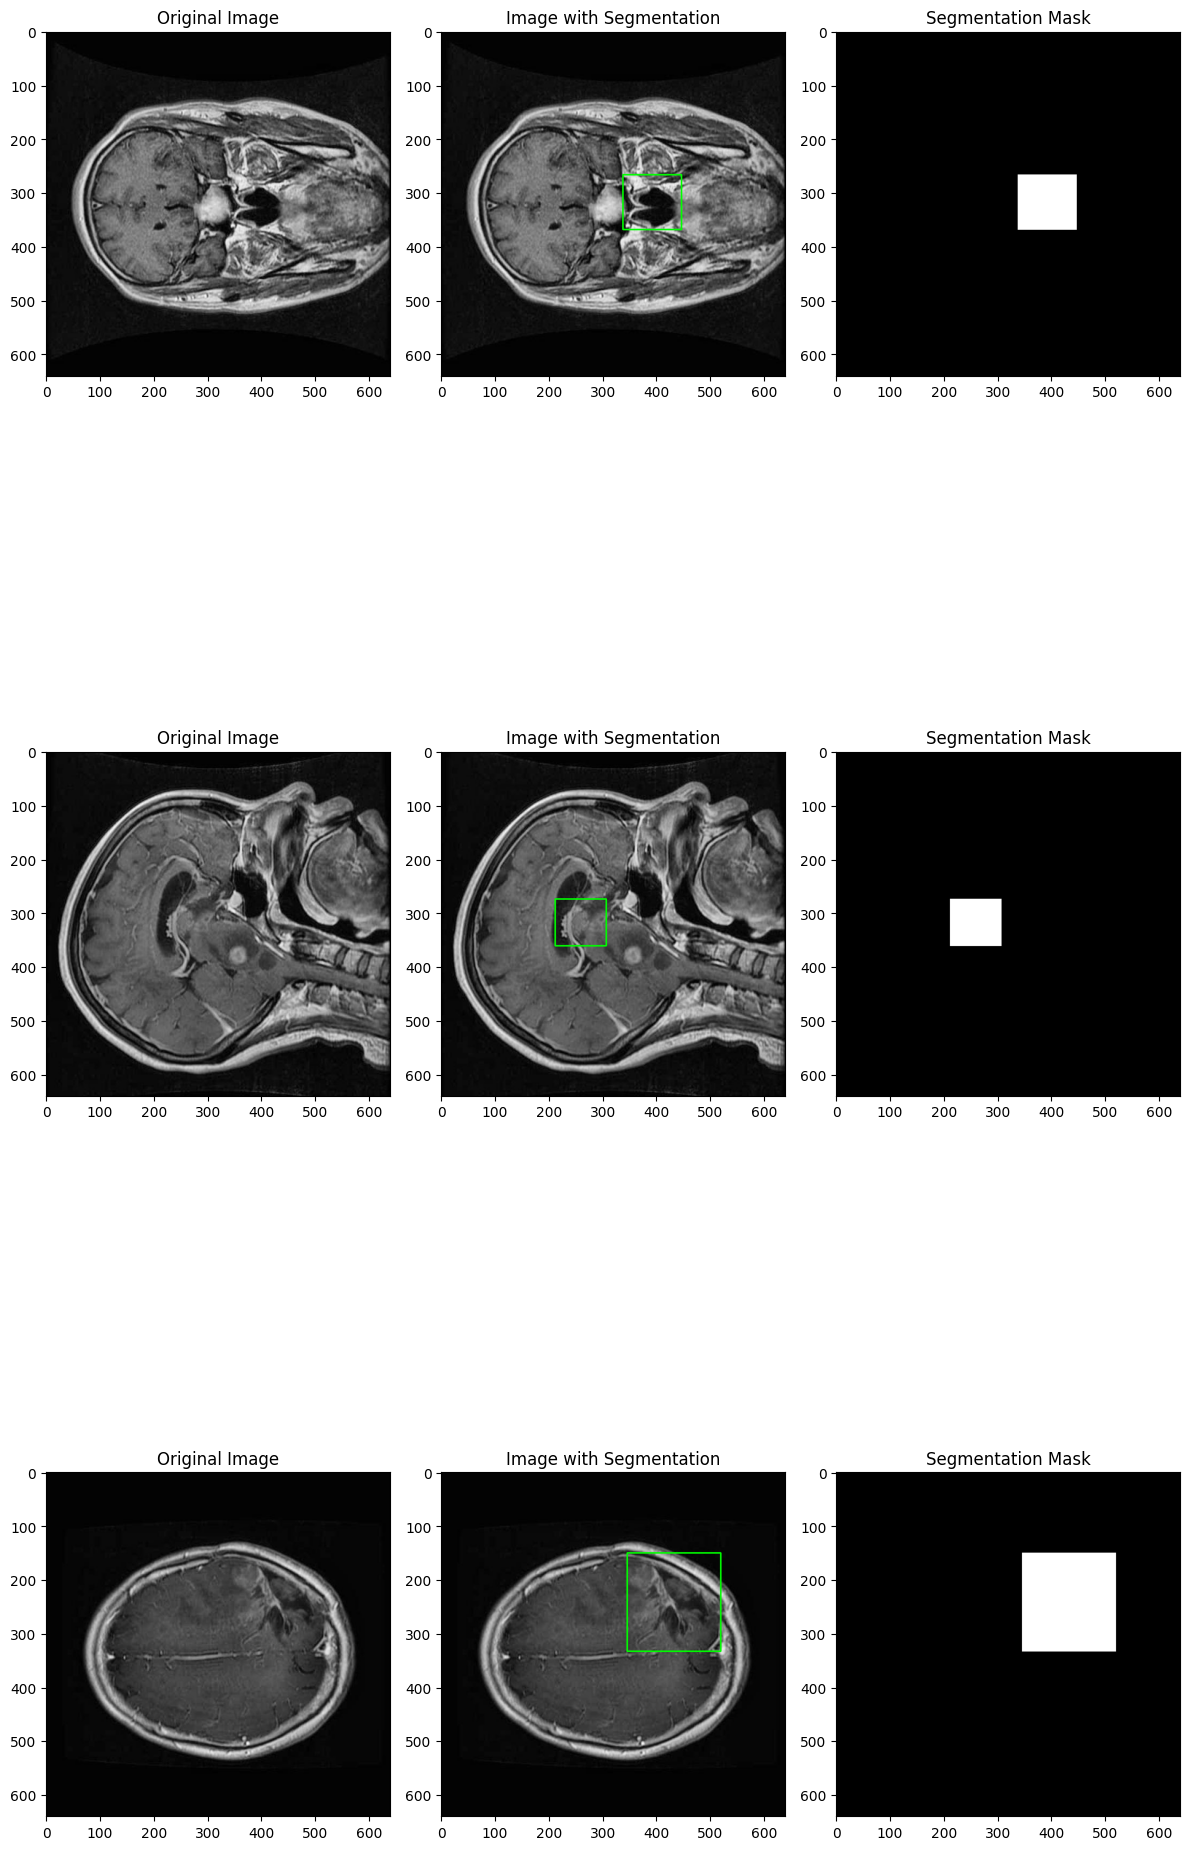

In [8]:
import matplotlib.pyplot as plt
import cv2
import numpy as np
import os

def visualize_random_images(n=3):
    # Select n random images
    indices = np.random.randint(0, len(train_annotation['images']), size=n)

    # Image and Annotation Retrieval:
    images = [train_annotation['images'][i] for i in indices]
    annotations = [train_annotation['annotations'][i] for i in indices]

    j = 1
    plt.figure(figsize=(12, 4 * 2 * n))

    for img, ann in zip(images, annotations):
        # Construct the full image path, assuming 'file_name' key contains the filename
        img_path = os.path.join(train_path, img['file_name'])

        # Load the image
        image = cv2.imread(img_path)

        # Check if the image was loaded properly
        if image is None:
            print(f"Error: Could not load image {img['file_name']}")
            continue

        # Convert image color to RGB
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # Show original image
        plt.subplot(n, 3, j)
        plt.imshow(image)
        plt.title("Original Image")
        j += 1

        # Create masked images from annotations
        segmentation = ann['segmentation'][0]  # Assuming a single polygon for simplicity
        segmentation = np.array(segmentation, dtype=np.int32).reshape(-1, 2)  # Convert to 2D (Nx2)

        # Make a copy of the image to draw on
        img_with_segmentation = image.copy()

        # Draw the segmentation boundary on the image
        cv2.polylines(img_with_segmentation, [segmentation], isClosed=True, color=(0, 255, 0), thickness=2)  # Green color with thickness 2

        # Show the image with segmentation boundary
        plt.subplot(n, 3, j)
        plt.imshow(img_with_segmentation)
        plt.title("Image with Segmentation")
        j += 1

        # Create a mask using the segmentation
        mask = np.zeros((image.shape[0], image.shape[1]), dtype=np.uint8)
        cv2.fillPoly(mask, [segmentation], color=1)

        # Show the mask
        plt.subplot(n, 3, j)
        plt.imshow(mask, cmap='gray')
        plt.title("Segmentation Mask")
        j += 1

    # Display all images
    plt.tight_layout()
    plt.show()

visualize_random_images()

In [9]:
# Print segmentation data for debugging
def inspect_segmentation(annotation):
    print("Segmentation data:", annotation['segmentation'])

# Inspect the segmentation for a sample annotation
inspect_segmentation(train_annotation['annotations'][0])

Segmentation data: [[313.75, 238.75, 145, 238.75, 145, 401.25, 313.75, 401.25, 313.75, 238.75]]


## Preprocessing Function for Images and Segmentation Masks

This section defines and implements the function `preprocess_image_and_mask` to resize images and create binary masks from segmentation annotations.

In [10]:
# Define the preprocess_image_and_mask function
def preprocess_image_and_mask(image_path, annotation, target_size=(256, 256)):
    # Read and resize the image
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    original_size = image.shape[:2]
    image = cv2.resize(image, target_size)

    # Create an empty mask
    mask = np.zeros(target_size, dtype=np.uint8)

    # Handle multiple segmentation polygons (if any)
    for seg in annotation['segmentation']:
        segmentation = np.array(seg, dtype=np.float32).reshape(-1, 2)  # Convert to 2D array

        # Scale the segmentation coordinates according to the original image size
        scale_x = target_size[1] / original_size[1]  # Scaling based on width
        scale_y = target_size[0] / original_size[0]  # Scaling based on height
        segmentation[:, 0] *= scale_x  # Scale x-coordinates
        segmentation[:, 1] *= scale_y  # Scale y-coordinates

        # Fill the mask with the scaled segmentation
        cv2.fillPoly(mask, [segmentation.astype(np.int32)], color=1)

    return image, mask

# Print image and mask dimensions for verification
def check_dimensions(image, mask):
    print(f"Image shape: {image.shape}")
    print(f"Mask shape: {mask.shape}")

# Test on the first image and mask
sample_image, sample_mask = preprocess_image_and_mask(
    os.path.join(train_path, train_annotation['images'][0]['file_name']),
    train_annotation['annotations'][0]
)
check_dimensions(sample_image, sample_mask)

Image shape: (256, 256, 3)
Mask shape: (256, 256)


The `preprocess_image_and_mask` function:

* Resizes the input image to the target size (default: 256x256).

* Creates a binary mask from the segmentation annotations by scaling the coordinates of the polygons to fit the resized image.

* Returns both the preprocessed image and the corresponding mask.

## Visualization of Image and Mask

A function to verify the dimensions of the image and mask, followed by visualization of the segmentation points on the original image.

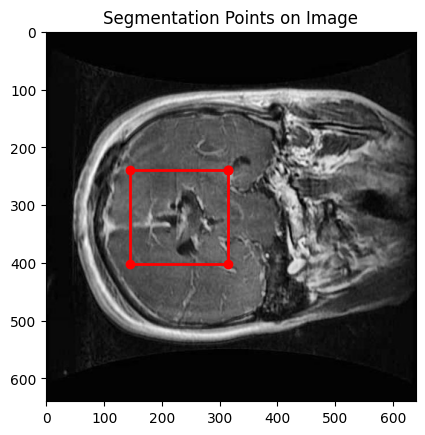

In [11]:
def visualize_segmentation_on_image(image_path, annotation):
    # Load the image
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Plot the image
    plt.imshow(image)

    # Overlay segmentation points
    for seg in annotation['segmentation']:
        segmentation = np.array(seg, dtype=np.float32).reshape(-1, 2)
        plt.plot(segmentation[:, 0], segmentation[:, 1], 'ro-', linewidth=2)

    plt.title("Segmentation Points on Image")
    plt.show()

# Visualize the segmentation on a sample image
visualize_segmentation_on_image(
    os.path.join(train_path, train_annotation['images'][0]['file_name']),
    train_annotation['annotations'][0]
)

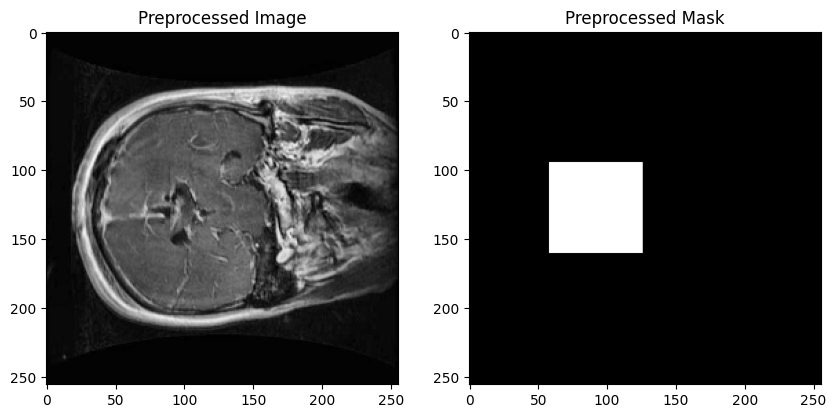

In [12]:
# Updated function to preprocess images and masks
def preprocess_image_and_mask(image_path, annotation, target_size=(256, 256)):
    # Read and resize the image
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    original_size = image.shape[:2]
    image = cv2.resize(image, target_size)

    # Create an empty mask
    mask = np.zeros(target_size, dtype=np.uint8)

    # Handle multiple segmentation polygons (if any)
    for seg in annotation['segmentation']:
        segmentation = np.array(seg, dtype=np.float32).reshape(-1, 2)  # Convert to 2D array

        # Scale the segmentation coordinates according to the original image size
        scale_x = target_size[1] / original_size[1]  # Scaling based on width
        scale_y = target_size[0] / original_size[0]  # Scaling based on height
        segmentation[:, 0] *= scale_x  # Scale x-coordinates
        segmentation[:, 1] *= scale_y  # Scale y-coordinates

        # Fill the mask with the scaled segmentation
        cv2.fillPoly(mask, [segmentation.astype(np.int32)], color=1)

    return image, mask

# Test the updated preprocessing function
sample_image, sample_mask = preprocess_image_and_mask(
    os.path.join(train_path, train_annotation['images'][0]['file_name']),
    train_annotation['annotations'][0]
)

# Display preprocessed image and mask
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(sample_image)
plt.title("Preprocessed Image")

plt.subplot(1, 2, 2)
plt.imshow(sample_mask, cmap='gray')
plt.title("Preprocessed Mask")
plt.show()

## Preprocessing the Entire Dataset

This section defines a function to preprocess all images and masks in the dataset, returning the preprocessed data in a format suitable for training a model.

In [13]:
# Function to preprocess the entire dataset
def preprocess_dataset(images, annotations, path, target_size=(256, 256)):
    preprocessed_images = []
    preprocessed_masks = []

    for i in range(len(images)):
        image_path = os.path.join(path, images[i]['file_name'])
        image, mask = preprocess_image_and_mask(image_path, annotations[i], target_size)
        preprocessed_images.append(image)
        preprocessed_masks.append(mask)

    # Convert lists to numpy arrays for model input
    preprocessed_images = np.array(preprocessed_images)
    preprocessed_masks = np.array(preprocessed_masks)

    # Normalize images (values between 0 and 1)
    preprocessed_images = preprocessed_images / 255.0

    # Reshape masks for binary classification (adding a channel dimension)
    preprocessed_masks = np.expand_dims(preprocessed_masks, axis=-1)

    return preprocessed_images, preprocessed_masks

# Preprocess training set
X_train, y_train = preprocess_dataset(
    train_annotation['images'],
    train_annotation['annotations'],
    train_path
)

# Preprocess validation set (assuming valid_annotation and valid_path are defined)
X_valid, y_valid = preprocess_dataset(
    valid_annotation['images'],
    valid_annotation['annotations'],
    valid_path
)

# Preprocess test set (assuming test_annotation and test_path are defined)
X_test, y_test = preprocess_dataset(
    test_annotation['images'],
    test_annotation['annotations'],
    test_path
)

# Print the shapes of the preprocessed datasets
print(f"Training set: {X_train.shape}, {y_train.shape}")
print(f"Validation set: {X_valid.shape}, {y_valid.shape}")
print(f"Test set: {X_test.shape}, {y_test.shape}")

Training set: (1502, 256, 256, 3), (1502, 256, 256, 1)
Validation set: (429, 256, 256, 3), (429, 256, 256, 1)
Test set: (215, 256, 256, 3), (215, 256, 256, 1)


The `preprocess_dataset` function:

* Iterates over the images and annotations to preprocess them using the previously defined `preprocess_image_and_mask` function.
* Normalizes the images (pixel values between 0 and 1) and reshapes the masks to include an additional channel dimension for binary classification.
* Returns the preprocessed images and masks as NumPy arrays, ready for model input.

## U-Net Model with Custom Loss and Dice Coefficient

In this section, we define the U-Net architecture and a custom loss function that combines binary crossentropy and the dice coefficient for better performance in segmentation tasks. The model is designed to capture both global context and local fine details using attention gates in the decoder path.

In [14]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Conv2DTranspose, concatenate, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import binary_crossentropy

# Dice coefficient for binary segmentation
def dice_coefficient(y_true, y_pred, smooth=1):
    y_true_f = tf.keras.backend.cast(y_true, 'float32')  # Convert y_true to float32
    y_pred_f = tf.keras.backend.flatten(y_pred)
    y_true_f = tf.keras.backend.flatten(y_true_f)

    intersection = tf.keras.backend.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (tf.keras.backend.sum(y_true_f) + tf.keras.backend.sum(y_pred_f) + smooth)

# Dice loss
def dice_loss(y_true, y_pred):
    return 1 - dice_coefficient(y_true, y_pred)


# Custom loss: binary crossentropy combined with dice loss
def combined_loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)

# U-Net model definition
def unet_model(input_size=(256, 256, 3)):
    inputs = Input(input_size)

    # Downsampling (Encoder)
    c1 = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    c1 = Conv2D(64, (3, 3), activation='relu', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = Conv2D(128, (3, 3), activation='relu', padding='same')(p1)
    c2 = Conv2D(128, (3, 3), activation='relu', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)

    c3 = Conv2D(256, (3, 3), activation='relu', padding='same')(p2)
    c3 = Conv2D(256, (3, 3), activation='relu', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)

    c4 = Conv2D(512, (3, 3), activation='relu', padding='same')(p3)
    c4 = Conv2D(512, (3, 3), activation='relu', padding='same')(c4)
    p4 = MaxPooling2D((2, 2))(c4)

    # Bottleneck
    c5 = Conv2D(1024, (3, 3), activation='relu', padding='same')(p4)
    c5 = Conv2D(1024, (3, 3), activation='relu', padding='same')(c5)

    # Upsampling (Decoder)
    u6 = Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(512, (3, 3), activation='relu', padding='same')(u6)
    c6 = Conv2D(512, (3, 3), activation='relu', padding='same')(c6)

    u7 = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(256, (3, 3), activation='relu', padding='same')(u7)
    c7 = Conv2D(256, (3, 3), activation='relu', padding='same')(c7)

    u8 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(128, (3, 3), activation='relu', padding='same')(u8)
    c8 = Conv2D(128, (3, 3), activation='relu', padding='same')(c8)

    u9 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1])
    c9 = Conv2D(64, (3, 3), activation='relu', padding='same')(u9)
    c9 = Conv2D(64, (3, 3), activation='relu', padding='same')(c9)

    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)

    model = Model(inputs=[inputs], outputs=[outputs])

    return model

# Create the model
model = unet_model()

# Compile the model with binary crossentropy + dice loss, and dice coefficient as a metric
model.compile(optimizer=Adam(learning_rate=1e-4),
              loss=combined_loss,
              metrics=['accuracy', dice_coefficient])

# Display model summary
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 256, 256,  │      1,792 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 256, 256,  │     36,928 │ conv2d[0][0]      │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 128, 128,  │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 128, 128,  │     73,856 │ max_pooling2d[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 128, 128,  │    147,584 │ conv2d_2[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 64, 64,    │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 64, 64,    │    295,168 │ max_pooling2d_1[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 64, 64,    │    590,080 │ conv2d_4[0][0]    │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 32, 32,    │          0 │ conv2d_5[0][0]    │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 32, 32,    │  1,180,160 │ max_pooling2d_2[… │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 32, 32,    │  2,359,808 │ conv2d_6[0][0]    │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 16, 16,    │          0 │ conv2d_7[0][0]    │
│ (MaxPooling2D)      │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 16, 16,    │  4,719,616 │ max_pooling2d_3[… │
│                     │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 16, 16,    │  9,438,208 │ conv2d_8[0][0]    │
│                     │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose    │ (None, 32, 32,    │  2,097,664 │ conv2d_9[0][0]    │
│ (Conv2DTranspose)   │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 32, 32,    │          0 │ conv2d_transpose

 Total params: 31,031,745 (118.38 MB)

 Trainable params: 31,031,745 (118.38 MB)

 Non-trainable params: 0 (0.00 B)

## Data Augmentation for Training and Validation

In order to improve the generalization of the model, **data augmentation** is applied to both training images and masks. Augmentation techniques such as rotation, shifts, shearing, zooming, and flipping are used to artificially expand the dataset and introduce variability.

In [15]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Data augmentation for images and masks
data_gen_args = dict(rotation_range=20,
                     width_shift_range=0.1,
                     height_shift_range=0.1,
                     shear_range=0.1,
                     zoom_range=0.2,
                     horizontal_flip=True,
                     fill_mode='nearest')

image_datagen = ImageDataGenerator(**data_gen_args)
mask_datagen = ImageDataGenerator(**data_gen_args)

# Create augmented data generators
image_generator = image_datagen.flow(X_train, batch_size=16, seed=42)
mask_generator = mask_datagen.flow(y_train, batch_size=16, seed=42)

# Combine the image and mask generators
train_generator = zip(image_generator, mask_generator)

# For validation, no augmentation is needed, so you can directly use the validation data
val_image_generator = ImageDataGenerator().flow(X_valid, batch_size=16, seed=42)
val_mask_generator = ImageDataGenerator().flow(y_valid, batch_size=16, seed=42)

# Combine validation image and mask generators
val_generator = zip(val_image_generator, val_mask_generator)

## Model Training with Callbacks

To ensure optimal training and prevent overfitting, several **callbacks** are used during model training. These include early stopping, model checkpointing, and learning rate reduction when the validation loss plateaus.

In [16]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

# Early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Model checkpoint to save the best model
checkpoint = ModelCheckpoint('/kaggle/working/unet_brain_tumor_segmentation.keras', monitor='val_loss', save_best_only=True)

# Reduce learning rate when the validation loss plateaus
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=1e-6)

# Train the model with the callbacks
history = model.fit(X_train, y_train,
                    validation_data=(X_valid, y_valid),
                    epochs=50,
                    batch_size=16,
                    callbacks=[early_stopping, checkpoint, reduce_lr])

Epoch 1/50


I0000 00:00:1728052865.177701     123 service.cc:145] XLA service 0x7c0bd4009f80 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1728052865.177778     123 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1728052901.208362     123 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


94/94 ━━━━━━━━━━━━━━━━━━━━ 119s 822ms/step - accuracy: 0.9435 - dice_coefficient: 0.0575 - loss: 1.3724 - val_accuracy: 0.9619 - val_dice_coefficient: 0.1454 - val_loss: 0.9880 - learning_rate: 1.0000e-04
Epoch 2/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 35s 369ms/step - accuracy: 0.9620 - dice_coefficient: 0.1762 - loss: 0.9689 - val_accuracy: 0.9619 - val_dice_coefficient: 0.2033 - val_loss: 0.9584 - learning_rate: 1.0000e-04
Epoch 3/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 35s 370ms/step - accuracy: 0.9615 - dice_coefficient: 0.2234 - loss: 0.9195 - val_accuracy: 0.9619 - val_dice_coefficient: 0.2330 - val_loss: 0.9062 - learning_rate: 1.0000e-04
Epoch 4/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 35s 369ms/step - accuracy: 0.9583 - dice_coefficient: 0.2363 - loss: 0.8995 - val_accuracy: 0.9170 - val_dice_coefficient: 0.2449 - val_loss: 0.9038 - learning_rate: 1.0000e-04
Epoch 5/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 35s 369ms/step - accuracy: 0.9291 - dice_coefficient: 0.2489 - loss: 0.8899 - val_accuracy: 0.9567 - val_dice_co

* `EarlyStopping`: Stops training if the validation loss doesn't improve for 5 consecutive epochs, restoring the best weights to prevent overfitting.

* `ModelCheckpoint`: Saves the best model during training based on validation loss.

* `ReduceLROnPlateau`: Reduces the learning rate by a factor of 0.1 when the validation loss stagnates, helping the model fine-tune and avoid getting stuck in local minima.

The model is trained for up to 50 epochs with a batch size of 16, using these callbacks to optimize training.

## Model Evaluation on Test Set

After training, the model is evaluated on the test dataset to assess its performance in terms of loss, accuracy, and the dice coefficient.

In [17]:
# Evaluate on the test set
test_loss, test_acc, test_dice_coeff = model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_acc}")
print(f"Test Dice Coefficient: {test_dice_coeff}")

7/7 ━━━━━━━━━━━━━━━━━━━━ 42s 3s/step - accuracy: 0.9758 - dice_coefficient: 0.6377 - loss: 0.4592
Test Loss: 0.4522228240966797
Test Accuracy: 0.9763497710227966
Test Dice Coefficient: 0.6387396454811096


## Plotting Training History and Visualizing Predictions

After training and testing the model, it's important to visualize the training progress and compare the predicted segmentation masks with the ground truth to evaluate the model's performance.


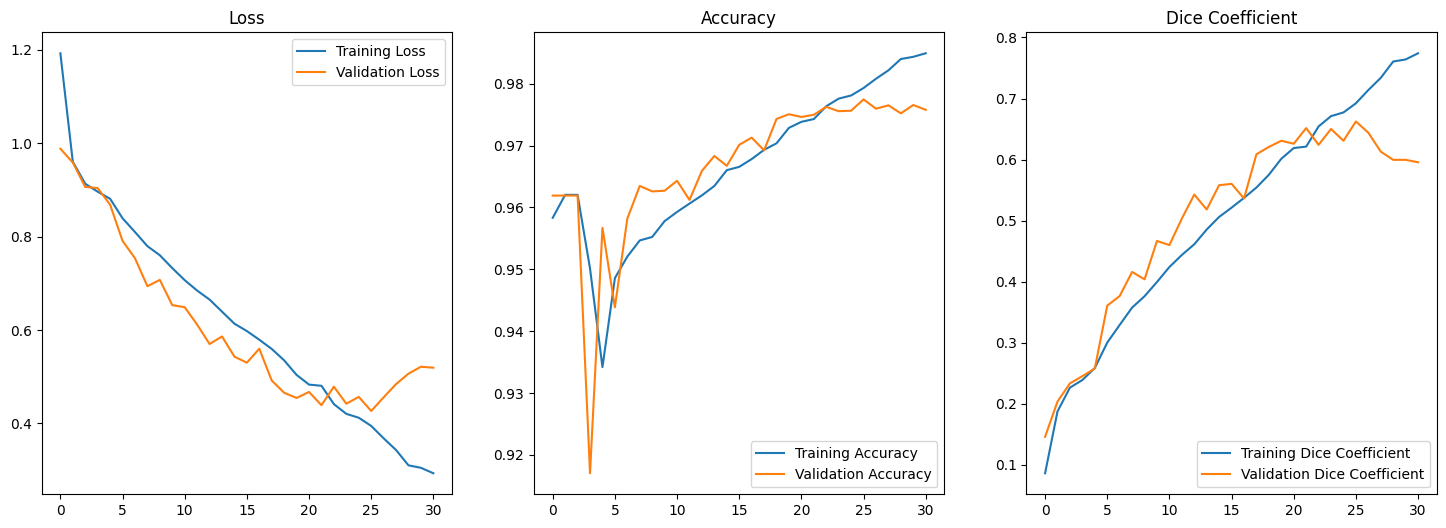

In [18]:
# Plot training & validation loss, accuracy, and dice coefficient
def plot_training_history(history):
    plt.figure(figsize=(18, 6))

    # Plot loss
    plt.subplot(1, 3, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Loss')

    # Plot accuracy
    plt.subplot(1, 3, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Accuracy')

    # Plot dice coefficient
    plt.subplot(1, 3, 3)
    plt.plot(history.history['dice_coefficient'], label='Training Dice Coefficient')
    plt.plot(history.history['val_dice_coefficient'], label='Validation Dice Coefficient')
    plt.legend(loc='lower right')
    plt.title('Dice Coefficient')

    plt.show()

# Call the function after training completes
plot_training_history(history)

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


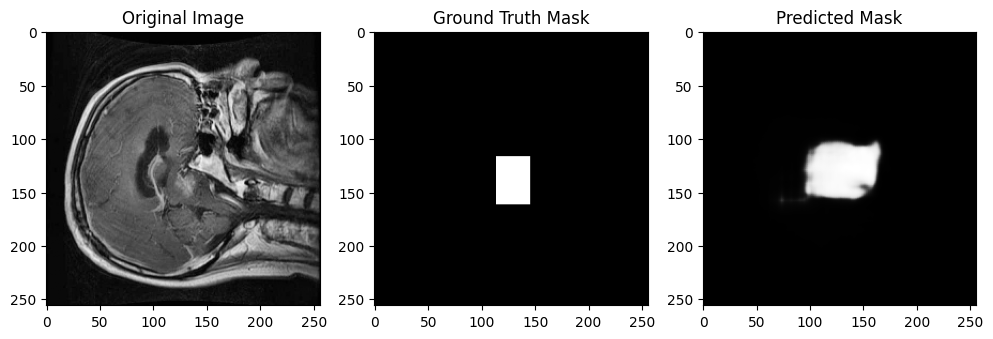

In [19]:
import random

# Predict on a random test image
idx = random.randint(0, len(X_test) - 1)
predicted_mask = model.predict(np.expand_dims(X_test[idx], axis=0))[0]

# Plot the original image, ground truth mask, and predicted mask
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.imshow(X_test[idx])
plt.title("Original Image")

plt.subplot(1, 3, 2)
plt.imshow(y_test[idx].squeeze(), cmap='gray')
plt.title("Ground Truth Mask")

plt.subplot(1, 3, 3)
plt.imshow(predicted_mask.squeeze(), cmap='gray')
plt.title("Predicted Mask")
plt.show()